In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV file into a pandas DataFrame
df1 = pd.read_csv('/kaggle/input/food-com-recipes-and-user-interactions/RAW_recipes.csv')
df2 = pd.read_csv('/kaggle/input/food-com-recipes-and-user-interactions/RAW_interactions.csv')
# Print the first five rows of the DataFrame to check if the data was loaded correctly
df1.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [2]:
# df3 = pd.read_csv('/content/drive/MyDrive/rs_final/PP_users.csv')

In [3]:
# df = pd.read_csv('/kaggle/input/food-com-recipes-and-user-interactions/RAW_recipes.csv')


In [4]:
print(df1['minutes'][0])

55


In [5]:
df1.columns.values

array(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients'], dtype=object)

In [6]:
df1 = df1.drop(['contributor_id', 'submitted', 'tags', 'n_steps', 'steps',
       'n_ingredients'], axis=1)

In [7]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
for i in df1.index:
  nutri = df1.at[i,'nutrition']
  ingred = df1.at[i,'ingredients']
  # print(type(item))
  nutri = nutri.replace('[','')
  ingred = ingred.replace('[\'','')
  nutri = nutri.replace(']','')
  ingred = ingred.replace('\']','')
  nutri = nutri.split(', ')
  ingred = ingred.split('\', \'')
  df1.at[i,'nutrition']=[float(i) for i in nutri]
  df1.at[i,'ingredients']=ingred

In [9]:
nutri_sum = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0])
for i in df1.index:
    lst = df1.at[i,'nutrition']
    nutri_sum+=np.array(lst)
nutri_sum= nutri_sum/len(df1)
print(nutri_sum)


[473.94242457  36.08069954  84.29686535  30.14748507  34.68185998
  45.58915027  15.5604027 ]


In [10]:
print(type(df1.at[0,'nutrition'][0]))

<class 'float'>


In [11]:
import gensim
from nltk.corpus import stopwords

# Join the list of words in the "ingredients" column into a string
df1['ingredients_str'] = df1['ingredients'].apply(lambda x: ' '.join(x))

# Concatenate the "description" and "ingredients" columns into a single text item
df1['text'] = df1['description'] + ' ' + df1['ingredients_str']
df1['text'] = df1['text'].astype(str)

# Tokenize the text
tokenizer = nltk.RegexpTokenizer(r'\w+')
df1['tokens'] = df1['text'].apply(lambda x: tokenizer.tokenize(x.lower()))

# Remove stop words and punctuations 
stop_words = set(stopwords.words('english'))
df1['tokens'] = df1['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

# Train the Word2Vec model
model = gensim.models.Word2Vec(df1['tokens'].tolist(), min_count=1, vector_size=100, workers=4)

In [12]:
# Generate word embeddings for each text item in the dataframe
# df1['embedding'] = df1['tokens'].apply(lambda x: [model[word] for word in x if word in model.wv.key_to_index])
df1['embedding'] = df1['tokens'].apply(lambda x: [model.wv[word] for word in x if word in model.wv.key_to_index])



In [13]:
usr_rating ={}
for i in df2.index:
    uid= df2.at[i,'user_id']
    rate = df2.at[i,'rating']
    if(usr_rating.get(uid)==None):
        usr_rating[uid]=[rate]
    else:
        usr_rating[uid].append(rate)
        
usr_std = {}
for key in usr_rating:
    if(usr_std.get(key)==None):
        usr_std[key]=np.std(usr_rating[key])

usr_avg ={}
usr_cnt={}

for i in df2.index:
    uid= df2.at[i,'user_id']
    rate = df2.at[i,'rating']
    if(usr_avg.get(uid)==None):
        usr_cnt[uid]=1
        usr_avg[uid]=rate
    else:
        usr_cnt[uid]+=1
        usr_avg[uid]+=rate

for key in usr_avg:
    usr_avg[key]=usr_avg[key]/usr_cnt[key]
    usr_avg[key]=round(usr_avg[key],2)

In [14]:
new_rating = {}
for i in df2.index:
    uid=df2.at[i,'user_id']
    rate = df2.at[i,'rating']
    if(usr_std[uid]!=0):
        df2.at[i,'rating'] = round((rate-usr_avg[uid])/usr_std[uid],2)
    else:
        df2.at[i,'rating'] = 0

In [15]:
df1.head()

,name,id,minutes,nutrition,description,ingredients,ingredients_str,text,tokens,embedding
0,arriba baked winter squash mexican style,137739,55,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",autumn is my favorite time of year to cook! th...,"[winter squash, mexican seasoning, mixed spice...",winter squash mexican seasoning mixed spice ho...,autumn is my favorite time of year to cook! th...,"[autumn, favorite, time, year, cook, recipe, p...","[[1.8117511, 0.1857123, 1.5488316, -0.579445, ..."
1,a bit different breakfast pizza,31490,30,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",this recipe calls for the crust to be prebaked...,"[prepared pizza crust, sausage patty, eggs, mi...",prepared pizza crust sausage patty eggs milk s...,this recipe calls for the crust to be prebaked...,"[recipe, calls, crust, prebaked, bit, adding, ...","[[-0.3105963, 0.25773194, 0.7452904, -0.874135..."
2,all in the kitchen chili,112140,130,"[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",this modified version of 'mom's' chili was a h...,"[ground beef, yellow onions, diced tomatoes, t...",ground beef yellow onions diced tomatoes tomat...,this modified version of 'mom's' chili was a h...,"[modified, version, mom, chili, hit, 2004, chr...","[[0.44727805, -0.04014846, -0.2069998, -0.5362..."
3,alouette potatoes,59389,45,"[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]","this is a super easy, great tasting, make ahea...","[spreadable cheese with garlic and herbs, new ...",spreadable cheese with garlic and herbs new po...,"this is a super easy, great tasting, make ahea...","[super, easy, great, tasting, make, ahead, sid...","[[1.1084706, -0.4837759, 1.0875937, -1.7939274..."
4,amish tomato ketchup for canning,44061,190,"[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",my dh's amish mother raised him on this recipe...,"[tomato juice, apple cider vinegar, sugar, sal...",tomato juice apple cider vinegar sugar salt pe...,my dh's amish mother raised him on this recipe...,"[dh, amish, mother, raised, recipe, much, pref...","[[-2.6818068, 2.2686703, 0.29813728, 1.2067087..."


In [16]:
# merged_df = pd.merge(df1, df2, left_on='id', right_on='recipe_id')

In [17]:
# df1.drop_duplicates(inplace=True)

In [18]:
# df3.head()

In [19]:
# for item in df3['items']:
#   item = item.replace('[','')
#   item = item.replace(']','')
#   item = item.split(',')
#   # print(item)

# print(map)

In [20]:
# df3.at[0,'items'][5]

In [21]:
# map = {}

# for i in df3.index:
#   item = df3.at[i,'items']
#   rating = df3.at[i,'ratings']
#   # print(type(item))
#   item = item.replace('[','')
#   rating = rating.replace('[','')
#   item = item.replace(']','')
#   rating = rating.replace(']','')
#   item = item.split(', ')
#   rating = rating.split(', ')
#   df3.at[i,'items']=item
#   df3.at[i,'ratings']=rating
#   for recipe in item:
#     if(map.get(recipe)==None):
#       map[recipe] = 1
#     else:
#       map[recipe]+=1
#   # print(i)

In [22]:
df2.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,-2,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,0,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,0,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,0,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,0,"Made the cheddar bacon topping, adding a sprin..."


In [23]:
map = {}
for i in df2.index:
  rid = df2.at[i,'recipe_id']
  if(map.get(rid)==None):
    map[rid] = 1;
  else:
    map[rid]+=1;

In [24]:
sorted_recipes = sorted(map,key= map.get, reverse=True)
sorted_recipes = sorted_recipes[:20]
print(sorted_recipes)

[2886, 27208, 89204, 39087, 67256, 54257, 22782, 32204, 69173, 68955, 33919, 82102, 25885, 28148, 135350, 26110, 99476, 10744, 129926, 33671]


In [25]:
top20 = []
for idx in sorted_recipes:
    top20.append(df1.at[df1.index.values[df1['id']==idx][0],'name'])
print(top20)

['best banana bread', 'to die for crock pot roast', 'crock pot chicken with black beans   cream cheese', 'creamy cajun chicken pasta', 'best ever banana cake with cream cheese frosting', 'yes  virginia there is a great meatloaf', 'jo mama s world famous spaghetti', 'whatever floats your boat  brownies', 'kittencal s italian melt in your mouth meatballs', 'japanese mum s chicken', 'creamy burrito casserole', 'kittencal s moist cheddar garlic oven fried chicken breast', 'banana banana bread', 'oven fried chicken chimichangas', 'fannie farmer s classic baked macaroni   cheese', 'southern buttermilk biscuits', 'the best easy beef and broccoli stir fry', 'delicious chicken pot pie', 'simply sour cream chicken enchiladas', 'crock pot whole chicken']


In [26]:
# user_embeddings = {}
# for i in df3.index:
#   user_embeddings[i]=[]
#   for recipe in sorted_recipes:
#     if recipe in df3.at[i,'items']:
#       user_embeddings[i].append(int(df3.at[i,'ratings'][df3.at[i,'items'].index(recipe)])
#     else:
#       user_embeddings[i].append(0) # can be replaced with mean ratings of the user
# print(user_embeddings)
# print(map['99787'])

In [27]:
user_embeddings = {}
user_who_rated = {}
for i in df2.index:
  uid = df2.at[i,'user_id']
  user_embeddings[uid] = [0 for i in range(20)]
  user_who_rated[uid] = 0


In [28]:
for i in df2.index:
  uid = df2.at[i,'user_id']
  rid = df2.at[i,'recipe_id']
  rating = df2.at[i,'rating']
  if rid in sorted_recipes:
    ind = sorted_recipes.index(rid)
    lst = user_embeddings[uid]
    lst[ind] = rating
    user_embeddings[uid] = lst
    user_who_rated[uid] = user_who_rated[uid] + 1


In [29]:
for i in df2.index:
  rid = df2.at[i,'recipe_id']
  if(rid == 27208): 
    print(df2.iloc[i])
    break

user_id                                                 103224
recipe_id                                                27208
date                                                2004-10-25
rating                                                       0
review       Can't add anything that hasn't already been sa...
Name: 634084, dtype: object


In [30]:
user_embeddings.get(103224)

[0, 0, 0, 0, 0, 0, -2, 0, 0, -2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [31]:
emb_avg = []
count = 0;
for i in df1.index:
  list_of_lists = df1.at[i,'embedding']
  # Create a new list with zeros of the same length as the sublists
  avg_list = [0] * len(list_of_lists[0])

  # Calculate the sum of each element across all sublists
  for sublist in list_of_lists:
      for i, num in enumerate(sublist):
          avg_list[i] += num

  # Divide each element by the number of sublists to get the average
  avg_list = [x / len(list_of_lists) for x in avg_list]
  emb_avg.append(avg_list)
  if(count%10000 == 0):
    print(count)
  count = count + 1


0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000


In [32]:
# df1['emb_avg'] = df1['embedding'].apply(lambda x: [sum(sublist)/len(sublist) for sublist in x])

In [33]:
df1['emb_avg'] = emb_avg

In [34]:
item_embeddings = {}
for i in df1.index:
  uid = df1.at[i,'id']
  item_embeddings[uid] = df1.at[i,'emb_avg']

In [35]:
df2.shape

(1132367, 5)

In [36]:
X = []
y = []
for i in df2.index:
  uid = df2.at[i,'user_id']
  rid = df2.at[i,'recipe_id']
  rating = df2.at[i,'rating']
  if(user_who_rated[uid]>4):
        X.append(user_embeddings.get(uid) + item_embeddings.get(rid))
        y.append(rating)

In [37]:
len(X)

114837

In [38]:
X = np.array(X)
y = np.array(y)

In [39]:
# Calculate the mean of each column, excluding zeros
col_means = np.true_divide(X.sum(0), (X != 0).sum(0))

# Replace zeros with column means
X[X == 0] = np.take(col_means, np.where(X == 0)[1])

In [40]:
X[0][:20]

array([-1.60238751, -1.50649044, -2.27295047, -0.1628218 , -1.        ,
       -4.42523148, -1.42570865, -2.00019608, -0.95403003, -0.68682727,
       -1.17961766, -1.        , -3.49475066, -2.09447599, -1.04079498,
       -4.13351614, -1.09824462, -1.66369578, -1.34709397, -2.42300962])

In [41]:
from sklearn.model_selection import train_test_split
train_X, test_X = train_test_split(X, test_size=0.2, random_state=42)
train_y, test_y = train_test_split(y, test_size=0.2, random_state=42)


In [42]:
from lightgbm import LGBMRegressor
model = LGBMRegressor(num_iterations=2000,learning_rate=0.05,n_estimators=500,num_leaves=64,max_depth=18)
model.fit(train_X, train_y)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LGBMRegressor(learning_rate=0.05, max_depth=18, n_estimators=500,
              num_iterations=2000, num_leaves=64)

In [43]:
from sklearn.metrics import accuracy_score

# Make predictions on the training data
train_y_pred = model.predict(train_X)
# Round off the predictions
train_y_pred = np.round(train_y_pred)
# Calculate the training accuracy
train_accuracy = accuracy_score(train_y, train_y_pred)

# Make predictions on the testing data
test_y_pred = model.predict(test_X)
# Round off the predictions
test_y_pred = np.round(test_y_pred)
# Calculate the testing accuracy
test_accuracy = accuracy_score(test_y, test_y_pred)

print(f'Training Accuracy: {train_accuracy}')
print(f'Testing Accuracy: {test_accuracy}')

Training Accuracy: 0.905659145087026
Testing Accuracy: 0.8157436433298503


In [44]:
import xgboost as xg
xgb_r = xg.XGBRegressor(num_iterations=1000,learning_rate=0.05,n_estimators=200,num_leaves=64,max_depth=12)
xgb_r.fit(train_X, train_y)

[07:37:46] WARNING: ../src/learner.cc:627: 
Parameters: { "num_iterations", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_iterations=1000, num_leaves=64, num_parallel_tree=1,
             predictor='auto', random_state=0, ...)

In [45]:
from sklearn.metrics import accuracy_score

# Make predictions on the training data
train_y_pred = xgb_r.predict(train_X)
# Round off the predictions
train_y_pred = np.round(train_y_pred)
# Calculate the training accuracy
train_accuracy = accuracy_score(train_y, train_y_pred)

# Make predictions on the testing data
test_y_pred = xgb_r.predict(test_X)
# Round off the predictions
test_y_pred = np.round(test_y_pred)
# Calculate the testing accuracy
test_accuracy = accuracy_score(test_y, test_y_pred)

print(f'Training Accuracy: {train_accuracy}')
print(f'Testing Accuracy: {test_accuracy}')

Training Accuracy: 0.8877749839445297
Testing Accuracy: 0.8413009404388715


In [46]:
train_X.shape

(91869, 120)

In [47]:
import torch
import torch.nn as nn

In [48]:
train_X_tensor = torch.tensor(train_X, dtype=torch.float32).to("cuda")
train_y_tensor = torch.tensor(train_y, dtype=torch.float32).unsqueeze(1).to("cuda")

In [49]:
test_X_tensor = torch.tensor(test_X, dtype=torch.float32).to("cuda")
test_y_tensor = torch.tensor(test_y, dtype=torch.float32).unsqueeze(1).to("cuda")

In [58]:
losslst = []
class RegressionNet(nn.Module):
    def __init__(self):
        super(RegressionNet, self).__init__()
        self.hidden1 = nn.Linear(120, 256)
        self.batchnorm1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.3)
        self.hidden2 = nn.Linear(256, 128)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.2)
        self.hidden5 = nn.Linear(128, 92)
        self.batchnorm5 = nn.BatchNorm1d(92)
        self.dropout5 = nn.Dropout(0.15)
        self.hidden3 = nn.Linear(92, 64)
        self.batchnorm3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.1)
        self.hidden4 = nn.Linear(64, 32)
        self.batchnorm4 = nn.BatchNorm1d(32)
        self.dropout4 = nn.Dropout(0.05)
        self.output = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.hidden1(x)
        x = self.batchnorm1(x)
        x = self.dropout1(x)
        x = self.relu(x)
        x = self.hidden2(x)
        x = self.batchnorm2(x)
        x = self.dropout2(x)
        x = self.relu(x)
        x = self.hidden5(x)
        x = self.batchnorm5(x)
        x = self.dropout5(x)
        x = self.relu(x)
        x = self.hidden3(x)
        x = self.batchnorm3(x)
        x = self.dropout3(x)
        x = self.relu(x)
        x = self.hidden4(x)
        x = self.batchnorm4(x)
        x = self.dropout4(x)
        x = self.relu(x)
        x = self.output(x)
        return x

# Create an instance of the model
model = RegressionNet().to("cuda")

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Train the model
batch_size = 128
num_epochs = 200
num_batches = int(len(train_X_tensor) / batch_size)

In [59]:
for epoch in range(num_epochs):
    for batch in range(num_batches):
        # Generate mini-batch
        batch_X = train_X_tensor[batch * batch_size : (batch + 1) * batch_size]
        batch_y = train_y_tensor[batch * batch_size : (batch + 1) * batch_size]

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the model on the training set
    with torch.no_grad():
        train_outputs = model(train_X_tensor)
        train_loss = criterion(train_outputs, train_y_tensor)
        train_acc = 1 - train_loss.item() / torch.mean((train_y_tensor - torch.mean(train_y_tensor))**2).item()
    losslst.append(train_loss.item())
    print(f"Epoch {epoch+1} - Training loss: {train_loss.item()}, Training accuracy: {train_acc}")



Epoch 1 - Training loss: 0.5820478796958923, Training accuracy: 3.819562632434437e-05
Epoch 2 - Training loss: 0.5798993706703186, Training accuracy: 0.003729347225482016
Epoch 3 - Training loss: 0.579364001750946, Training accuracy: 0.004649114291554124
Epoch 4 - Training loss: 0.5787168741226196, Training accuracy: 0.005760883500677272
Epoch 5 - Training loss: 0.5781776905059814, Training accuracy: 0.006687204239898881
Epoch 6 - Training loss: 0.5777439475059509, Training accuracy: 0.00743237735722313
Epoch 7 - Training loss: 0.5772914290428162, Training accuracy: 0.008209806834579947
Epoch 8 - Training loss: 0.5769800543785095, Training accuracy: 0.008744750405406121
Epoch 9 - Training loss: 0.5767862796783447, Training accuracy: 0.009077656521170985
Epoch 10 - Training loss: 0.5761269330978394, Training accuracy: 0.010210417964601204
Epoch 11 - Training loss: 0.576305091381073, Training accuracy: 0.009904340948291956
Epoch 12 - Training loss: 0.5752935409545898, Training accuracy: 

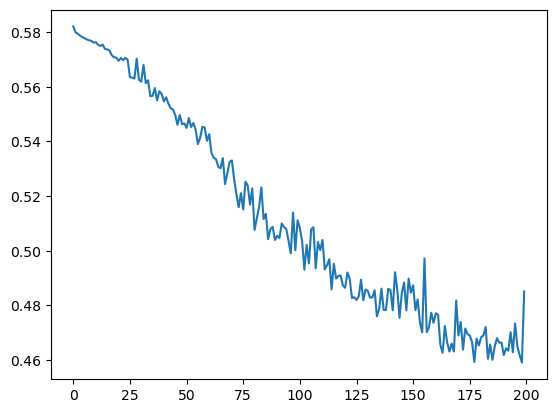

In [60]:
plt.plot(losslst[:])

In [61]:
# Evaluate the model on the test set
with torch.no_grad():
    test_outputs = model(test_X_tensor)
    test_loss = criterion(test_outputs, test_y_tensor)
    test_acc = 1 - test_loss.item() / torch.mean((test_y_tensor - torch.mean(test_y_tensor))**2).item()

print(f"Test loss: {test_loss.item()}, Test accuracy: {test_acc}")

Test loss: 0.5640824437141418, Test accuracy: -0.017603948208261055


In [62]:
# Get the predicted output on the training data
train_outputs = model(train_X_tensor)

# Convert the predicted output and the training target to numpy arrays
train_outputs_np = train_outputs.to("cpu").detach().numpy()
train_y_np = train_y_tensor.to("cpu").detach().numpy()

# Round the predicted output to the nearest integer
train_outputs_rounded = np.round(train_outputs_np)

# Calculate the number of correct predictions
num_correct = np.sum(train_outputs_rounded == train_y_np)

# Calculate the training accuracy
accuracy = num_correct / len(train_y_np)
print(f"Training accuracy: {accuracy:.4f}")

Training accuracy: 0.8673


In [63]:
# len(test_y_np)

In [64]:
test_outputs = model(test_X_tensor)

# Convert the predicted output and the training target to numpy arrays
test_outputs_np = test_outputs.to("cpu").detach().numpy()
test_y_np = test_y_tensor.to("cpu").detach().numpy()

# Round the predicted output to the nearest integer
test_outputs_rounded = np.round(test_outputs_np)

# Calculate the number of correct predictions
num_correct = 0
for i in range(len(test_outputs_rounded)):
    if(train_outputs_rounded[i] == test_y_np[i]):
        num_correct = num_correct+1

# # Calculate the training accuracy
accuracy = num_correct / len(test_y_np)
print(f"Testing accuracy: {accuracy:.4f}")

Testing accuracy: 0.8562


In [65]:
train_outputs_rounded[0]

array([-0.], dtype=float32)

In [66]:
test_y_np[0]

array([0.], dtype=float32)

In [109]:
newuser = [0,0,3,5,1,0,2,2,5,1,3,3,3,0,0,2,4,2,1,4]
stand=np.std(newuser)
stand
mean=np.mean(newuser)
if(stand!=0):
    for i in range(len(newuser)):
        newuser[i]=(newuser[i]-mean)/stand
new_ingredients = ['onion', 'gingerroot', 'garam masala','beef','steak', 'tomato paste', 'chicken stock', 'single cream', 'boneless chicken breasts', 'salt & pepper', 'butter','eggs','tomato paste','prepared pizza crust','butter','garam masala','salt', 'flour', 'garlic powder', 'oil', 'chicken rice soup']
nutrition_sensitivity = 0.9
time_needed = 1000

In [110]:
print(type(df1.at[0,'nutrition'][0]))

<class 'float'>


In [111]:
avail_recipes=[]
for i in df1.index:
    recipe_ingred = df1.at[i,'ingredients']
    time = df1.at[i,'minutes']
#     print(recipe_ingred)
    flag = 0
    for j in recipe_ingred:
        if j not in new_ingredients:
            flag = 1
            break
    if (flag == 0 and time<time_needed):
        avail_recipes.append(df1.at[i,'id'])

In [112]:
print(avail_recipes)

[65521, 227335, 262538, 375710, 47651, 11846, 398819, 29431, 180624, 138082, 1825, 113019, 203819, 98280]


In [113]:
print(df1.at[df1.index.values[df1['id']==309425][0],'name'])

eat sum more  shortbread cookies


In [114]:
newuser_dataset = []
nutri_values = []
for rid in avail_recipes:
    newuser_dataset.append(newuser+item_embeddings[rid])
    nutri_values.append(df1.at[df1.index.values[df1['id']==rid][0],'nutrition'])

In [115]:
print((nutri_values))

[[153.2, 17.0, 0.0, 4.0, 3.0, 36.0, 3.0], [634.0, 59.0, 68.0, 53.0, 89.0, 81.0, 10.0], [193.9, 23.0, 1.0, 11.0, 25.0, 33.0, 0.0], [148.9, 16.0, 4.0, 5.0, 21.0, 21.0, 0.0], [1561.9, 213.0, 1.0, 50.0, 22.0, 438.0, 23.0], [553.0, 12.0, 3.0, 3.0, 42.0, 11.0, 31.0], [65.1, 8.0, 0.0, 1.0, 0.0, 18.0, 0.0], [118.6, 17.0, 6.0, 3.0, 0.0, 36.0, 1.0], [124.4, 16.0, 1.0, 4.0, 12.0, 26.0, 0.0], [71.5, 7.0, 0.0, 3.0, 12.0, 7.0, 0.0], [956.2, 59.0, 4.0, 54.0, 57.0, 34.0, 40.0], [7.0, 0.0, 2.0, 218.0, 0.0, 0.0, 0.0], [11.6, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0], [3060.0, 495.0, 0.0, 4.0, 74.0, 668.0, 0.0]]


In [116]:
newuser_dataset_tensor = torch.tensor(newuser_dataset, dtype=torch.float32).to("cuda")
new_outputs = model(newuser_dataset_tensor)

# Convert the predicted output and the training target to numpy arrays
new_outputs_np = new_outputs.to("cpu").detach().numpy()
new_outputs_np = new_outputs_np.flatten()
domain = []
ratings_pred = []
domain.append(np.min(new_outputs_np))
domain.append(np.max(new_outputs_np))
rng = 1
if (domain[1]-domain[0])!=0:
    rng = (domain[1]-domain[0])
for i in new_outputs_np:
    ratings_pred.append((i-domain[0])/rng)


In [117]:
print(ratings_pred)

[0.0, 0.92875606, 0.8362087, 0.8793333, 0.96064997, 0.9408544, 0.93843484, 0.95737517, 0.97138166, 0.85907704, 0.82817316, 1.0, 0.90954375, 0.9036108]


In [118]:
# calorie,total fat,sugar,sodium,protein,saturated fat,carbs(pdv)
balanced_diet = [1.0,0.5,1.0,0.5,1.0,0.5,0.5]
high_protein = [1.0,0.5,0.5,0.5,3,0.5,1.5]
mean = [473.94242457,36.08069954,84.29686535,30.14748507,34.68185998,45.58915027,15.5604027] 

In [119]:
nutri_score = []
for i in range(len(new_outputs_np)):
    score = 0.0
    for j in range(len(nutri_values[0])):
        score+=(nutri_values[i][j]*high_protein[j])/mean[j]
#     print(nutri_score)
    nutri_score.append(score)
#     total_score.append((1-nutrition_sensititvity)*new_outputs_np[i]+nutrition_sensititvity*nutri_score
domain2 = []
ratings_pred2 = []
domain2.append(np.min(nutri_score))
domain2.append(np.max(nutri_score))
rng2 = 1
if (domain2[1]-domain2[0])!=0:
    rng2 = (domain2[1]-domain2[0])
for i in nutri_score:
    ratings_pred2.append((i-domain2[0])/rng2)

total_score = []
for i in range(len(ratings_pred2)):
    total_score.append((1-nutrition_sensitivity)*ratings_pred[i]+nutrition_sensitivity*ratings_pred2[i])

print(total_score)

[0.050567864879265144, 0.5232398500359903, 0.1964455129133812, 0.17577223440941542, 0.6267945222452238, 0.36328708071075044, 0.10761275409734702, 0.12946712431883267, 0.15804713812896848, 0.1312775601627642, 0.510696182650458, 0.21952701948183928, 0.09095437526702879, 0.9903610825538636]


In [120]:
sorted_recipes_indices = np.argsort(total_score)
sorted_recipes_indices = np.flip(sorted_recipes_indices)
print(sorted_recipes_indices)

[13  4  1 10  5 11  2  3  8  9  7  6 12  0]


In [121]:
sorted_names = []
for idx in sorted_recipes_indices:
    recipe = avail_recipes[idx]
    sorted_names.append(df1.at[df1.index.values[df1['id']==recipe][0],'name'])
print(sorted_names)

['venison  beef  veal  or lamb canned', 'gumbo base  aka roux', 'easy indian butter chicken', 'sugar kichelach', 'homemade pasta', 'super simple garlic salt', 'fried eggs', 'fried eggs with onion  ukrainian   russian', 'munavoi  finnish egg butter', 'perfect hard boiled eggs  technique', 'mama s leftover steak sublime', 'how to bake cakes in cans  aka tin can cakes', 'sweating onions', 'basic roux']
